In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam
import torchvision
import torchvision.models as models
from torchsummary import summary

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [2]:
batch_size = 256
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616]),
    ])

val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616])
    ])

train_set = CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=train_transform
)

val_set = CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=val_transform
)

trainloader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

testloader = DataLoader(
    val_set, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4,
)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [3]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)


class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(1024, num_classes)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.d4(out)
        out = self.e4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [4]:
model = GoogLeNet(num_classes=10).to(device)

In [5]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 192, 32, 32]           5,376
       BatchNorm2d-2          [-1, 192, 32, 32]             384
              ReLU-3          [-1, 192, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          12,352
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 96, 32, 32]          18,528
       BatchNorm2d-8           [-1, 96, 32, 32]             192
              ReLU-9           [-1, 96, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]         110,720
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           3,088
      BatchNorm2d-14           [-1, 16,

# Train

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)  

In [7]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [8]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 150

In [9]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{(epoch + 1):3}/{max_epoch:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.2f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [  1/150] 	 Loss: 1.21031     Accuracy: 55.81% 	 Test Loss: 1.30190     Test Accuracy: 56.80%
Epoch [  2/150] 	 Loss: 0.73486     Accuracy: 74.08% 	 Test Loss: 0.93844     Test Accuracy: 68.36%
Epoch [  3/150] 	 Loss: 0.54140     Accuracy: 81.16% 	 Test Loss: 1.20150     Test Accuracy: 62.65%
Epoch [  4/150] 	 Loss: 0.42868     Accuracy: 85.31% 	 Test Loss: 0.85204     Test Accuracy: 73.42%
Epoch [  5/150] 	 Loss: 0.34788     Accuracy: 88.03% 	 Test Loss: 0.56109     Test Accuracy: 82.02%
Epoch [  6/150] 	 Loss: 0.29026     Accuracy: 89.96% 	 Test Loss: 0.63893     Test Accuracy: 79.93%
Epoch [  7/150] 	 Loss: 0.23573     Accuracy: 91.87% 	 Test Loss: 0.58675     Test Accuracy: 81.62%
Epoch [  8/150] 	 Loss: 0.19170     Accuracy: 93.35% 	 Test Loss: 0.49480     Test Accuracy: 84.72%
Epoch [  9/150] 	 Loss: 0.15858     Accuracy: 94.49% 	 Test Loss: 0.69196     Test Accuracy: 80.55%
Epoch [ 10/150] 	 Loss: 0.13076     Accuracy: 95.53% 	 Test Loss: 0.65997     Test Accuracy: 82.50%


In [10]:
# the best accuracy
best_epoch = np.argmax(test_accuracies)
print(f"\nBest epoch: {best_epoch + 1} with test accuracy: {test_accuracies[best_epoch]:.2f}%")


Best epoch: 117 with test accuracy: 91.66%


# Plot results

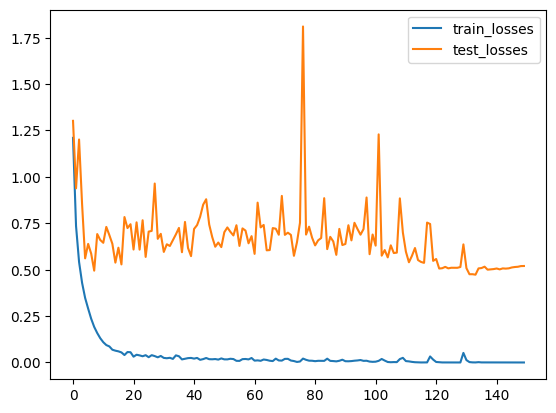

In [11]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

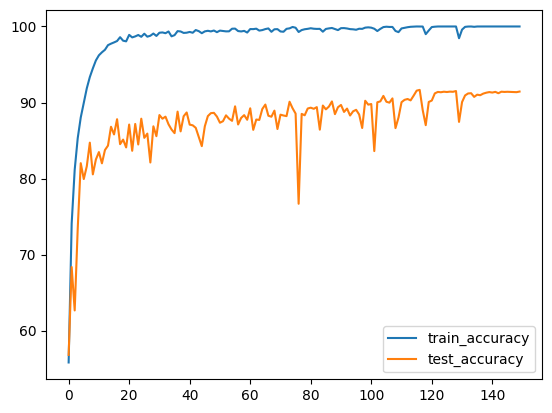

In [12]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()